# clinvar-conflicting EDA

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style(style='whitegrid')
sns.set(font_scale=1.5);

import pandas as pd

In [2]:
df = pd.read_csv('clinvar_conflicting.csv', dtype={0: object})

In [3]:
df.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,CLNDNINCL,CLNHGVS,CLNSIGINCL,CLNVC,CLNVI,GENEINFO,MC,ORIGIN,SSR,CLASS
0,1,955563,G,C,0.0000,0.00000,0.0000,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",NaN,NC_000001.10:g.955563G>C,NaN,single_nucleotide_variant,NaN,AGRN:375790,SO:0001583|missense_variant,1.0,NaN,0
1,1,955597,G,T,0.0000,0.42418,0.2826,MedGen:CN169374,NaN,not_specified,NaN,NC_000001.10:g.955597G>T,NaN,single_nucleotide_variant,NaN,AGRN:375790,SO:0001819|synonymous_variant,1.0,NaN,0
2,1,955619,G,C,0.0000,0.03475,0.0088,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",NaN,NC_000001.10:g.955619G>C,NaN,single_nucleotide_variant,NaN,AGRN:375790,SO:0001583|missense_variant,1.0,NaN,1
3,1,957640,C,T,0.0318,0.02016,0.0328,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",NaN,NC_000001.10:g.957640C>T,NaN,single_nucleotide_variant,NaN,AGRN:375790,SO:0001819|synonymous_variant,1.0,NaN,0
4,1,976059,C,T,0.0000,0.00022,0.0010,MedGen:CN169374,NaN,not_specified,NaN,NC_000001.10:g.976059C>T,NaN,single_nucleotide_variant,NaN,AGRN:375790,SO:0001819|synonymous_variant,1.0,NaN,1


In [4]:
# Check the CLASS distribution
df.CLASS.value_counts(normalize=True)

0    0.748011
1    0.251989
Name: CLASS, dtype: float64

In [5]:
# How many unique values are there for each column?
df.nunique()

CHROM              24
POS             63152
REF               866
ALT               459
AF_ESP           2851
AF_EXAC          6692
AF_TGP           2094
CLNDISDB         9244
CLNDISDBINCL       48
CLNDN            9271
CLNDNINCL          54
CLNHGVS         65245
CLNSIGINCL         68
CLNVC               7
CLNVI           26305
GENEINFO         2509
MC                 89
ORIGIN             27
SSR                 2
CLASS               2
dtype: int64

## CHROM

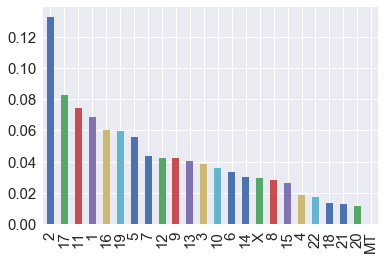

In [6]:
# Distribution of chromosomes
df.CHROM.value_counts(normalize=True).plot(kind='bar');

## CLNVC (Variant Type)

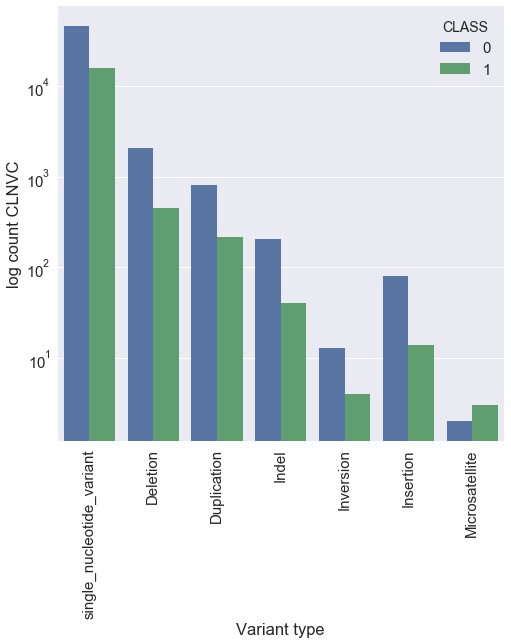

In [7]:
# CLNVC is the type of variant
plt.figure(figsize=(8,8))
g = sns.countplot(x="CLNVC", hue='CLASS', data=df,);
g.set(yscale="log")
g.set_ylabel("log count CLNVC")
g.set_xlabel("Variant type")
plt.xticks(rotation=90);

## MC (molecular consequence)

In [9]:
MC_list = df.MC.dropna().str.split(',').apply(lambda row: list((c.split('|')[1] for c in row)))
MC_encoded = pd.get_dummies(MC_list.apply(pd.Series).stack()).sum(level=0)
MC_encoded = MC_encoded.reindex(index=MC_list.index)

In [10]:
# Did we transfer the index correctly? Yes!
# 65228 should be missense
MC_encoded.loc[65228]

2KB_upstream_variant       0
3_prime_UTR_variant        0
500B_downstream_variant    0
5_prime_UTR_variant        0
frameshift_variant         0
intron_variant             0
missense_variant           1
nonsense                   0
splice_acceptor_variant    0
splice_donor_variant       0
synonymous_variant         0
Name: 65228, dtype: uint8

In [11]:
# Transformed MC feature
MC_encoded.head()

,2KB_upstream_variant,3_prime_UTR_variant,500B_downstream_variant,5_prime_UTR_variant,frameshift_variant,intron_variant,missense_variant,nonsense,splice_acceptor_variant,splice_donor_variant,synonymous_variant
0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,1


In [12]:
# counts of each type of variant
MC_encoded.sum()

2KB_upstream_variant         429
3_prime_UTR_variant          704
500B_downstream_variant       29
5_prime_UTR_variant         1990
frameshift_variant          1861
intron_variant             11970
missense_variant           26672
nonsense                    1783
splice_acceptor_variant      428
splice_donor_variant         579
synonymous_variant         18407
dtype: int64

In [13]:
# Incorporate the transformed MC feature into the existing DataFrame
df = df.join(MC_encoded).drop(columns=['MC'])

## Correlation

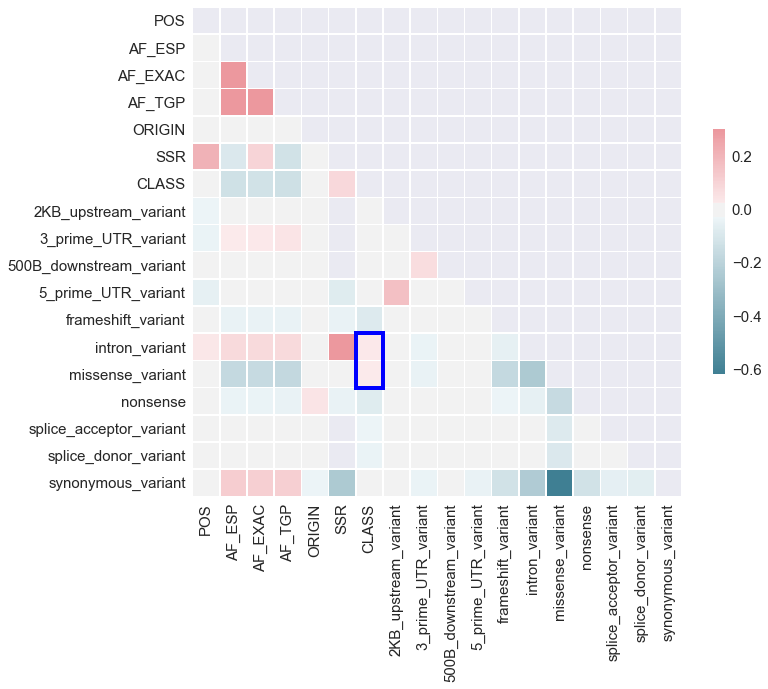

In [14]:
corr = df.corr()

import numpy as np
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True);

# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5});

from matplotlib.patches import Rectangle
#ax = g.ax_heatmap

g.add_patch(Rectangle((6, 12), 1, 2, fill=False, edgecolor='blue', lw=4));

**Notice the positive correlation of intronic and missense variants with conflicting classifications (dark blue box).  This fits our current understanding, these types of variants in particular are known to be ambiguous.**

## GENEINFO

In [15]:
# Genes by class
genes = df.groupby('CLASS').GENEINFO.value_counts(normalize=False)

# Counts of genes in the conflicting class that aren't in the non-conflicting class
genes[1].loc[genes[1].index.isin(set(genes[1].index) - set(genes[0].index))].head()

GENEINFO
CFB:629|C2:717                    6
DPM1:8813                         5
MRPS16:51021|DNAJC9-AS1:414245    4
NSUN2:54888                       4
ACSL4:2182                        3
Name: GENEINFO, dtype: int64

## Allele Frequencies

/anaconda3/envs/clinvar_py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


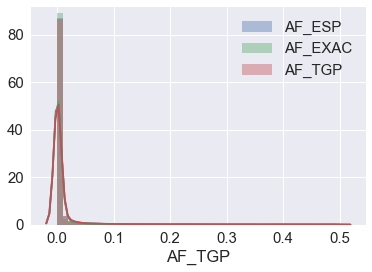

In [16]:
# most values are low
sns.distplot(df.AF_ESP, label="AF_ESP")
sns.distplot(df.AF_EXAC, label="AF_EXAC")
sns.distplot(df.AF_TGP, label="AF_TGP")
plt.legend();